In [31]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor 

import joblib
import matplotlib.pyplot as plt


In [32]:
pd.set_option("display.max_columns" , None)
sklearn.set_config(transform_output="default")

In [33]:
train_data = pd.read_csv("data/train.csv")
val_data = pd.read_csv("data/val.csv")
test_data = pd.read_csv("data/test.csv")

In [34]:
def split_df(data):
    X = data.drop(columns = "price")
    y = data["price"]
    return(X,y)

In [35]:
X_train , y_train = split_df(train_data)

In [36]:
y_train

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
635     4282
636    13067
637     4423
638     7670
639    10844
Name: price, Length: 640, dtype: int64

In [37]:
X_test , y_test = split_df(test_data)
print( X_test.shape , y_test.shape)

(200, 9) (200,)


In [38]:
X_val , y_val = split_df(val_data)
print( X_val.shape , y_val.shape)

(160, 9) (160,)


In [39]:
dt_cols = ["date_of_journey" , "dep_time" , "arrival_time"]
num_cols = ["duration", "total_stops"]
cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [40]:
cat_cols


['airline', 'source', 'destination', 'additional_info']

In [41]:
num_pipe = Pipeline(steps=[
    ("imputer" , SimpleImputer(strategy="median")),
    ("scaler" , StandardScaler())
])

In [42]:
cat_pipe = Pipeline(steps=[
    ("imputer" , SimpleImputer(strategy="most_frequent")),
    ("encoder" , OneHotEncoder(sparse_output=False))
])

In [43]:
doj = Pipeline(steps = [
    ("imputer" , SimpleImputer(strategy="most_frequent")),
    ("extractor" , DatetimeFeatures(features_to_extract= ["month" , "week" , "day_of_week" , "day_of_month"],format= "mixed")),
    ("scaler" ,StandardScaler())
])
time_pipe = Pipeline(steps = [
    ("imputer" , SimpleImputer(strategy="most_frequent")),
    ("extractor" , DatetimeFeatures(features_to_extract= ["hour" , "minute" ],format="mixed")),
    ("scaler" ,StandardScaler())
])

In [44]:
preprocessor  = ColumnTransformer(transformers=[
    ("num" , num_pipe , num_cols),
    ("cat" , cat_pipe , cat_cols),
    ("doj" , doj , ["date_of_journey"]),
    ("time" ,time_pipe , ["dep_time" , "arrival_time"])
])

In [45]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

In [46]:
## 5.Model Selection

In [47]:
 algorithms = {
    "Linear Regression": LinearRegression(),
    "SVM":SVR(),
    "Random Forest Classifier" : RandomForestRegressor(n_estimators=10),
    "Xg Boost":XGBRegressor(n_estimators=10)
 }

In [48]:
data = pd.concat([train_data,val_data],axis=0)
data

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
155,Spicejet,2019-04-03,Delhi,Cochin,08:45:00,13:15:00,270,1.0,No check-in baggage included,4098
156,Spicejet,2019-03-01,Mumbai,Hyderabad,05:45:00,07:05:00,80,0.0,No Info,12475
157,Multiple Carriers,2019-05-18,Delhi,Cochin,03:50:00,12:35:00,525,1.0,No Info,10197
158,Jet Airways,2019-03-01,Banglore,New Delhi,22:50:00,00:45:00,1555,1.0,No Info,26890


In [49]:
X_data , y_data= split_df(data)
print(X_data.shape , y_data.shape )

(800, 9) (800,)


In [50]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [51]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )
    
    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)

    # training curve
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )

    # test curve
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)
    ax.legend(loc="lower right")

    plt.show()

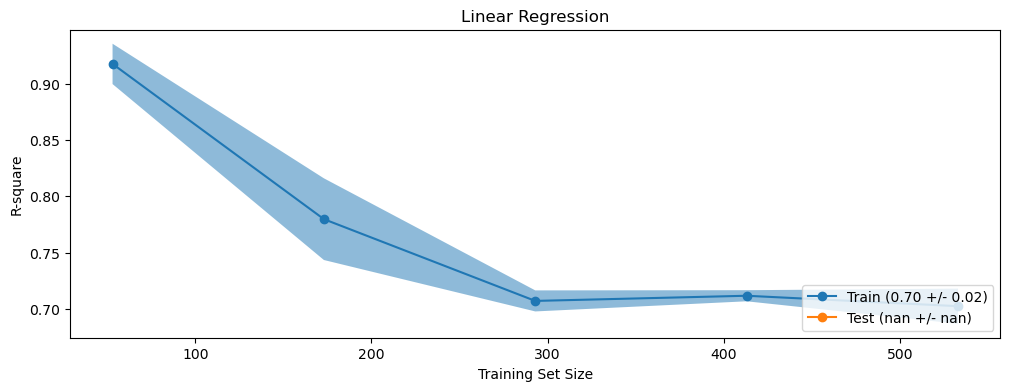

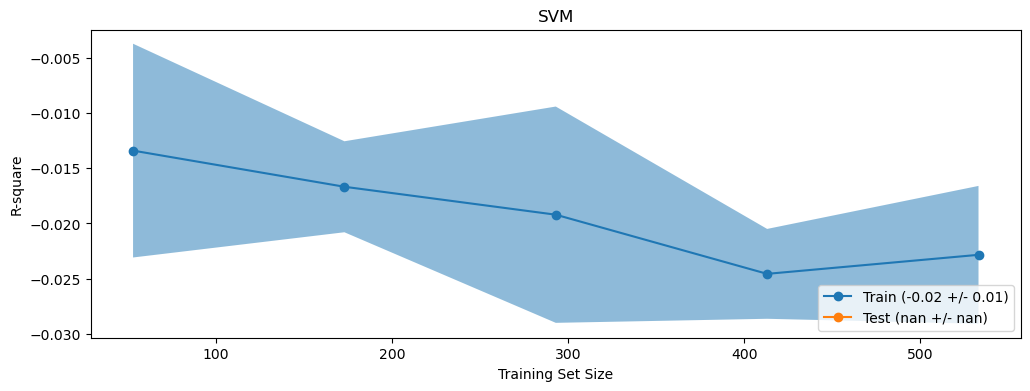

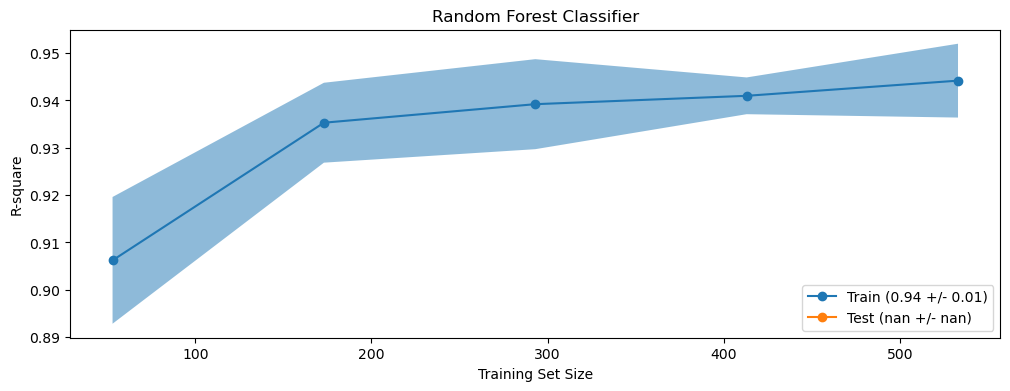

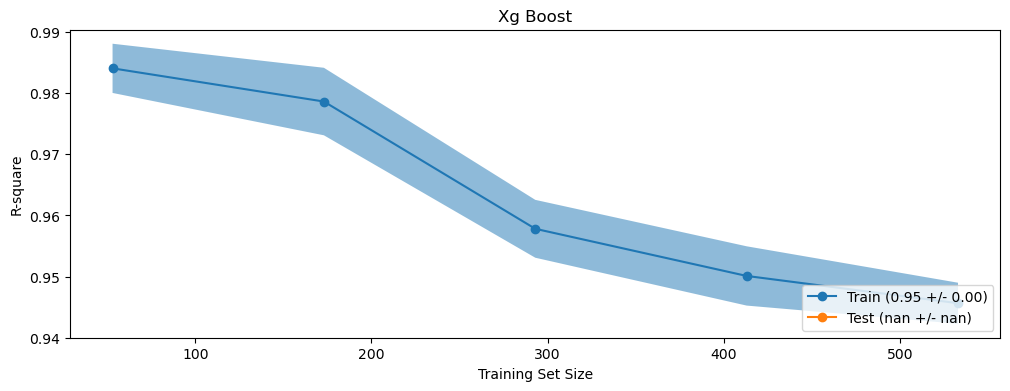

In [52]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

### Model Training


In [53]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [54]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['airline', 'source',
                                                   'destination',
                                                   'additional...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

# Model Evaluation

In [55]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [56]:
print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")

R2 score on Training data is = 0.9515568092450467


In [57]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")

R2 score on Test data is = 0.6950625747189996


## Model persistence

In [58]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [59]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['airline', 'source',
                                                   'destination',
                                                   'additional...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [61]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.6950625747189996